### Part 1-Training Custom Image Classifier in OpenCV in Tensorflow
### Part 2-Converting Our Classifier to ONNX format
### Part 3-Using the ONNX model directly in the OpenCV DNN Moddule

#### You have to do some process:
1 - Create new environment(conda create -n env_name)

2 - !pip install tensorflow==2.0

3 - !pip install opencv-contrib-python==4.0.0.21

4 - !pip install keras2onnx and onnx

5 - !pip install h5py==2.10.0

# Import the libraries

In [1]:
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import urllib.request
import tarfile 
from PIL import Image
import sys
import PIL
import scipy
import tensorflow.keras


# Set parameters

In [2]:
BATCH_SIZE=4
IMG_HEIGHT=224
IMG_WIDTH=224
SPLIT=0.25
EPOCHS=30

# Get files from url and download

In [3]:
url="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
filename="flower_photos.tgz"
urllib.request.urlretrieve(url,filename)
print("DONE!!")

DONE!!


# Unzip the file with manually

In [4]:
filename="flower_photos.tgz"
tarfile.open(filename).extractall()
print("UNZIPPED!!")

UNZIPPED!!


# Get class names and number of images

In [5]:
DIR_PATH="flower_photos/"

classes=[]

total_num_images=0

for class_name in os.listdir(DIR_PATH):
    class_path=os.path.join(DIR_PATH,class_name)
    
    if os.path.isdir(class_path):
        num_images=len(os.listdir(class_path))
        total_num_images+=num_images
        print(f"{class_name}:Found {num_images} images")
        
        
        classes.append(class_name)
        

print("-"*25)        
print(classes)
print(f"Total:{total_num_images} images")

daisy:Found 633 images
dandelion:Found 898 images
roses:Found 641 images
sunflowers:Found 699 images
tulips:Found 799 images
-------------------------
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Total:3670 images


# Data augmentation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train=ImageDataGenerator(rescale=1./255,
                                validation_split=SPLIT,
                                rotation_range=20,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='reflect')

datagen_validation=ImageDataGenerator(rescale=1./255,validation_split=SPLIT)
print("Generators was created!!")

Generators was created!!


In [7]:
train_gen=datagen_train.flow_from_directory(directory=DIR_PATH,
                                            target_size=(IMG_HEIGHT,IMG_WIDTH),
                                           batch_size=BATCH_SIZE,
                                           subset='training',
                                           shuffle=True)

validation_gen=datagen_validation.flow_from_directory(directory=DIR_PATH,
                                            target_size=(IMG_HEIGHT,IMG_WIDTH),
                                           batch_size=BATCH_SIZE,
                                           subset='validation',
                                            shuffle=True)

print("Generators was applied!!")

Found 2755 images belonging to 5 classes.
Found 915 images belonging to 5 classes.
Generators was applied!!


# Display some images

In [8]:
def showImages(data_gen):
    plt.figure(figsize=(20,20))
    
    img,labels=next(data_gen)
    
    
    for i in range(BATCH_SIZE):
        plt.subplot(2,2,i+1)
        
        #Get class name
        class_name=classes[np.argmax(labels[i])]
        
        #Set label of images
        plt.xlabel(str(class_name),fontsize=20)
        
        #Set title
        plt.suptitle("Some images of dataset",fontsize=28)
        
        plt.imshow(img[i])
        

In [9]:
img,labels=next(train_gen)
labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

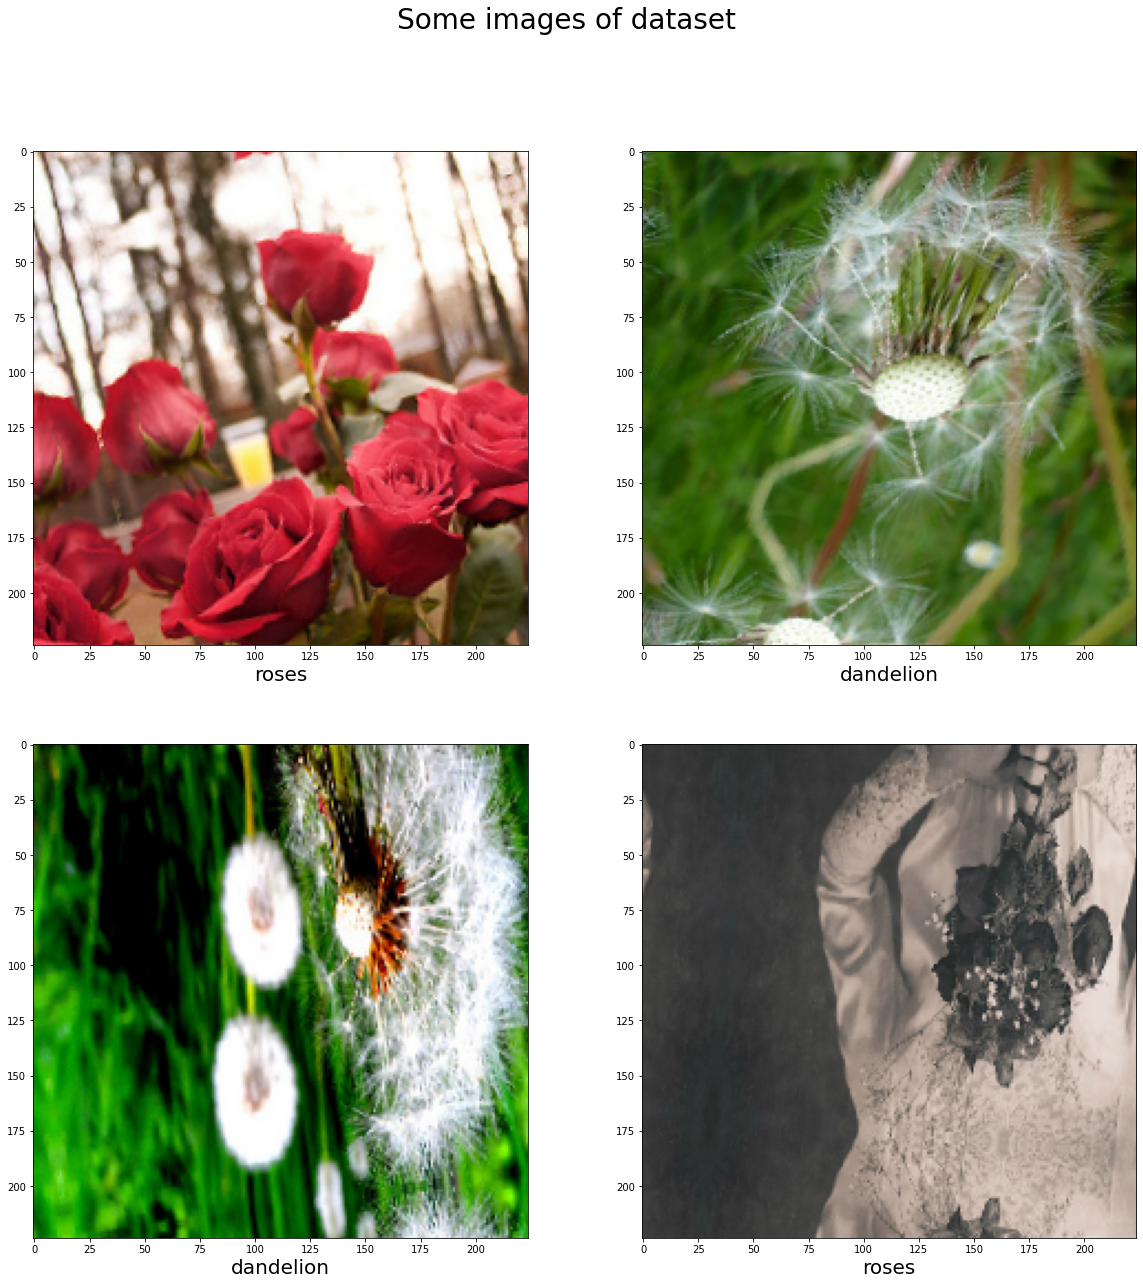

In [10]:
showImages(train_gen)

In [11]:
img,labels=next(train_gen)
img.shape

(4, 224, 224, 3)

# Build the model

In [12]:
#We should reset the generators because we displayed images by using generators and go to the first 
train_gen.reset()
validation_gen.reset()

model=tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=3,activation=tf.nn.relu,
                                 input_shape=(IMG_HEIGHT,IMG_WIDTH,3),padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))
          
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation=tf.nn.relu,padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation=tf.nn.relu,padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))
          
          
model.add(tf.keras.layers.Flatten())
          
model.add(tf.keras.layers.Dense(units=1024,activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(units=1024,activation=tf.nn.relu))

model.add(tf.keras.layers.Dense(units=5,activation=tf.nn.softmax))
          
print("MODEL CREATED!!")

MODEL CREATED!!


# Compile the model and set callbacks

In [13]:
callbacks=[]

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stopping=EarlyStopping(monitor='val_loss',patience=7,restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',patience=4,factor=0.1,
                           min_delta=0.001,min_lr=1e-8)

callbacks=[early_stopping,reduce_lr]

print("DONE!!")

DONE!!


In [14]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       36992     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0

# Training the model

In [15]:
history=model.fit(train_gen,epochs=EPOCHS,validation_data=validation_gen,
                  steps_per_epoch=len(train_gen)//BATCH_SIZE,
                  validation_steps=len(validation_gen)//BATCH_SIZE,
                  callbacks=callbacks)

Train for 172 steps, validate for 57 steps
Epoch 1/30
172/172 [==============================] - 170s 988ms/step - loss: 1.5504 - accuracy: 0.3009 - val_loss: 1.3431 - val_accuracy: 0.3947
Epoch 2/30
172/172 [==============================] - 166s 966ms/step - loss: 1.3043 - accuracy: 0.4375 - val_loss: 1.1580 - val_accuracy: 0.5175
Epoch 3/30
172/172 [==============================] - 164s 955ms/step - loss: 1.2186 - accuracy: 0.5015 - val_loss: 1.0912 - val_accuracy: 0.5746
Epoch 4/30
172/172 [==============================] - 164s 951ms/step - loss: 1.1624 - accuracy: 0.5349 - val_loss: 1.0245 - val_accuracy: 0.5658
Epoch 5/30
172/172 [==============================] - 164s 952ms/step - loss: 1.1086 - accuracy: 0.5523 - val_loss: 1.0506 - val_accuracy: 0.5965
Epoch 6/30
172/172 [==============================] - 162s 944ms/step - loss: 1.0972 - accuracy: 0.5669 - val_loss: 1.0125 - val_accuracy: 0.5965
Epoch 7/30
172/172 [==============================] - 162s 941ms/step - loss: 1.0

# Visualize the results

In [16]:
num_val_accuracy=int(len(train_gen)*model.evaluate(validation_gen)[1])

229/229 [==============================] - 22s 97ms/step - loss: 0.7941 - accuracy: 0.6907


In [17]:
print(f"Corrected {num_val_accuracy}/{len(train_gen)} validation dataset with the model. ")

Corrected 475/689 validation dataset with the model. 


In [18]:
train_acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
train_loss=history.history["loss"]
val_loss=history.history["val_loss"]

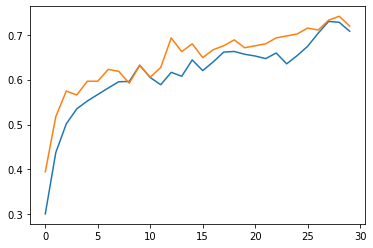

In [19]:
plt.plot(train_acc)
plt.plot(val_acc)

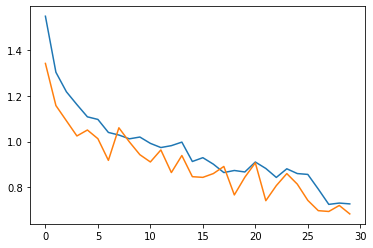

In [20]:
plt.plot(train_loss)
plt.plot(val_loss)

# Prediction any image

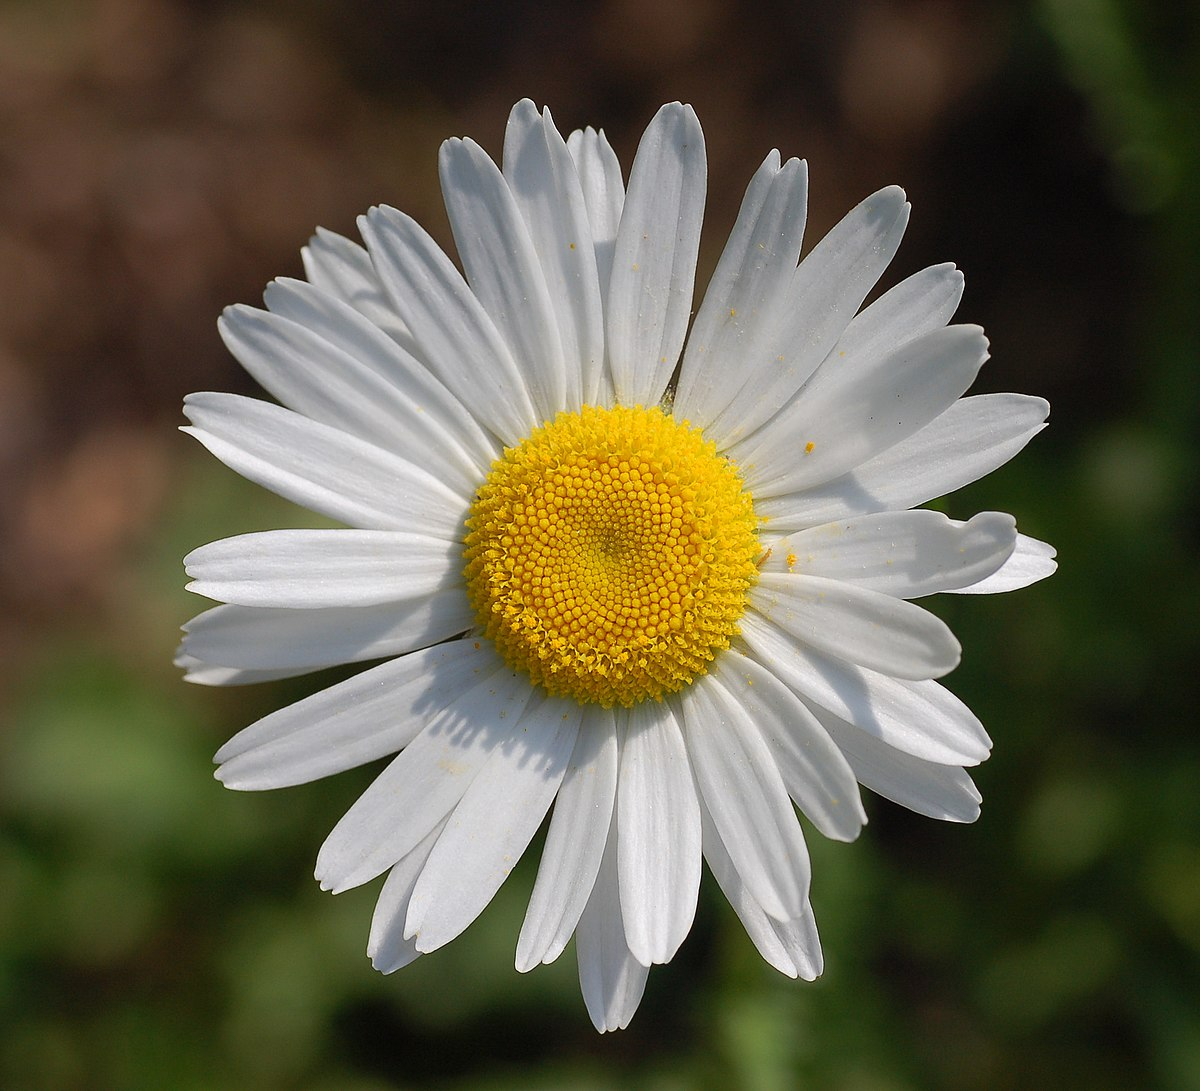

In [21]:
imgPIL=Image.open("daisy.jpg")
imgPIL

In [22]:
img=cv2.imread("daisy.jpg")
img=cv2.resize(img,(224,224))
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

img=np.array(img).astype('float64')/255.0
img=np.expand_dims(img,axis=0)
print(img.shape)

(1, 224, 224, 3)


In [23]:
pred=model.predict(img)
pred

array([[9.5194608e-01, 1.1567496e-02, 1.9146699e-02, 2.7663409e-04,
        1.7063040e-02]], dtype=float32)

In [24]:
class_id=np.argmax(pred[0])
probability=np.max(pred[0])

class_name=classes[int(class_id)]

print(f"Predicted class name : {class_name} with {probability:.2f} of confidence.")

Predicted class name : daisy with 0.95 of confidence.


# Saving the model and weights

In [26]:
model.save("model/flowersTF.h5")
model.save_weights("model/flowersTF_weights.h5")
print("MODEL SAVED!!")

MODEL SAVED!!


# Convert TF model to ONNX

In [30]:
"""
!pip install onnx
!pip install keras2onnx
"""

'\n!pip install onnx\n!pip install keras2onnx\n'

In [2]:
import onnx 
import keras2onnx

# Load the model
model=tf.keras.models.load_model("model/flowersTF.h5")

# Convert the model to ONNX format
model_onnx=keras2onnx.convert_keras(model,model.name)

# Save the model
onnx.save_model(model_onnx,"model/flowers_converted.onnx")
print("ONNX Model saved!!")

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 39 -> 21


ONNX Model saved!!
